## Imports

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
sns.set_theme(style="darkgrid", palette="magma")
from matplotlib import pyplot as plt

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from imblearn.under_sampling import OneSidedSelection, NeighbourhoodCleaningRule, RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

## Load Dataset

In [2]:
df = pd.read_csv('taskdata.csv')

## Initial checks

### Let's look at the structure of our database

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4407 entries, 0 to 4406
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                4407 non-null   int64  
 1   account_id             4400 non-null   float64
 2   max_return_days        4407 non-null   int64  
 3   average_return_days    4407 non-null   float64
 4   customer_since_months  4407 non-null   int64  
 5   total_revenue          4407 non-null   float64
 6   average_revenue        4407 non-null   float64
 7   avg_vas_count          4407 non-null   float64
 8   avg_used_vas_value     4407 non-null   float64
 9   business_type          4407 non-null   int64  
 10  avg_wallet_bonus       4407 non-null   float64
 11  avg_active_ads         4407 non-null   float64
 12  avg_new_ads            4407 non-null   float64
 13  avg_email_replies      4407 non-null   float64
 14  avg_call_replies       4407 non-null   float64
 15  avg_

### It looks like we have 7 missing values in  `account_id` Colomn  
We will most likely remove these records as they dont even make 1% of records  

### `user_id` colomn consists of unique feilds  
Id colomns do not describe records therefore are basically useless

### Removing `user_id` and missing records from `account_id`

In [4]:
df = df.drop(labels=['user_id'], axis=1).dropna().reset_index(drop=True)

## Checking for balance

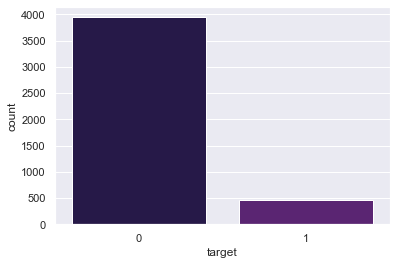

In [5]:
sns.countplot(data=df, x=df["target"])

#### Data is quite unbalanced as seen in the plot  
we will use **undersampling** followed by **oversampling** to restore balance and improve the quality of dataset

### Checking correlation

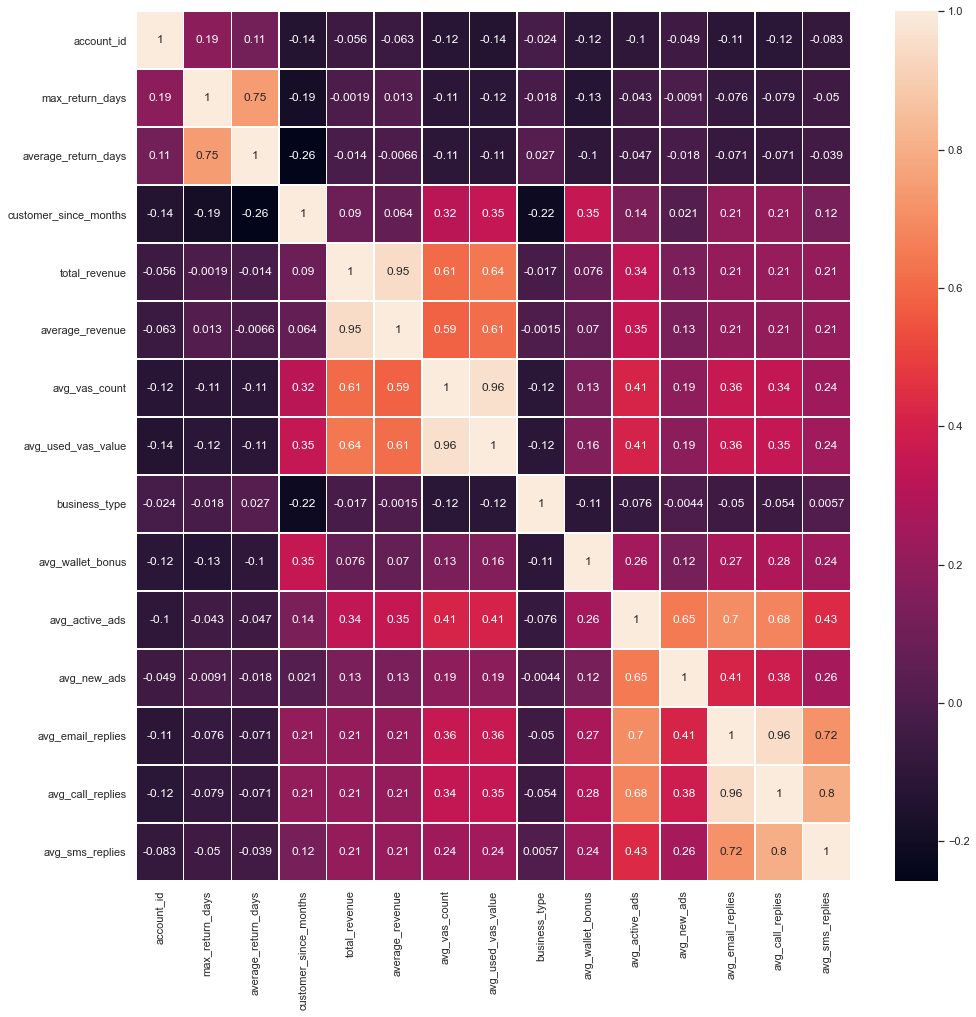

In [6]:
plt.figure(figsize=(16,16))
sns.heatmap(data=df.loc[:, df.columns!="target"].corr(), linewidths=0.5, annot=True)

#### These columns highly overlap each other therefore we can safely remove one from each pair
We wont remove any colomns right now as we need them for comparisons and deriving new colomns

#### Noted columns that can be removed:
**=>** `total_revenue` `average_revenue`  
**=>** `avg_vas_count` `avg_used_vas_value`  
**=>** `avg_email_replies` `avg_call_replies`  

### performing ANOVA

#### ANOVA basically tells us effect of colomns on each other while training models
It uses f-tests for variance analysis

In [7]:
kbest = SelectKBest(score_func=f_classif, k=10).fit(df.loc[:, df.columns!="target"], df["target"])
pd.DataFrame({
    "columns": df.columns[:-1],
    "scores": kbest.scores_,
    "pvalues": kbest.pvalues_
}).sort_values(by="scores", ascending=False).reset_index(drop=True)

,columns,scores,pvalues
0,max_return_days,361.226618,1.797637e-77
1,customer_since_months,257.627890,2.193587e-56
2,average_return_days,124.809843,1.354508e-28
3,avg_used_vas_value,73.797809,1.185180e-17
4,account_id,66.381355,4.797423e-16
5,avg_vas_count,61.202618,6.402510e-15
6,avg_wallet_bonus,26.082722,3.409352e-07
7,avg_call_replies,25.024021,5.882851e-07
8,avg_email_replies,22.079886,2.695230e-06
9,avg_sms_replies,17.146656,3.525059e-05


#### Lower the score of ANOVA analysis less is the effect of that colomn while training
We will be selecting the top 10 colomns based on their ANOVA scores

#### Noted columns that can be removed:
**=>** `total_revenue`  
**=>** `average_revenue	`  
**=>** `avg_new_ads`  
**=>** `avg_active_ads`   
**=>** `business_type`  

# EDA + New Features  

### Looking at Data

#### Looking at columns that will be removed!  
These are the columns that we will remove as their contribution in model training is less.

<Figure size 1152x2304 with 0 Axes>

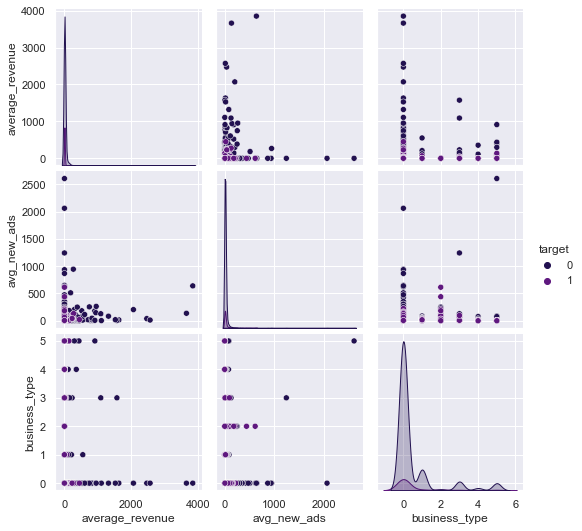

In [8]:
plt.figure(figsize=(16, 32))
sns.pairplot(df[['average_revenue', 'avg_new_ads', 'business_type', 'target']].sort_values("target"), hue="target")

Not that imp!!
<hr>

### Looking at related coloumns!

#### We look at these columns first as they are related 
`'avg_wallet_bonus'`, `'avg_call_replies'`, `'avg_email_replies'`, `'avg_sms_replies'`

<Figure size 1152x2304 with 0 Axes>

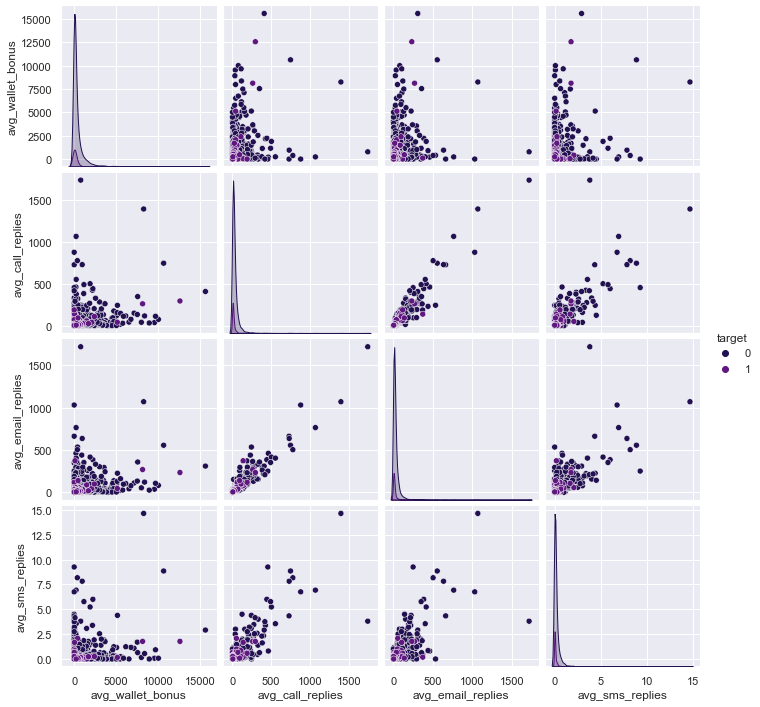

In [9]:
plt.figure(figsize=(16, 32)) 
sns.pairplot(df[['avg_wallet_bonus', 'avg_call_replies', 'avg_email_replies', 'avg_sms_replies', 'target']]
             .sort_values("target"), hue="target")

From our data we can make out that most of the targets in our database are the once with low calls, wallet bonus, emails & sms replies.  
This is clearly evident if you look at the histograms.

**`Most of the targets have low Interactivity`**

#### Inserting column `interactive`  specifing weather a user has contacted the company in any way
condition: `avg_wallet_bonus` `avg_email_replies` `avg_call_replies` `avg_sms_replies` should be less than their mean  
This will be a boolean column.  
1 **=>** user is interactive  
0 **=>** user is not interactive

In [10]:
df.insert(df.shape[1] - 1, "interactive", np.where((
        (df["avg_wallet_bonus"]<df["avg_wallet_bonus"].mean()) |
        (df["avg_email_replies"]<df["avg_email_replies"].mean()) |
        (df["avg_call_replies"]<df["avg_call_replies"].mean()) |
        (df["avg_sms_replies"]<df["avg_sms_replies"].mean())
    ),
    1, 0
))

<hr>

### Customer Since Month

This colomn may provide solid information!

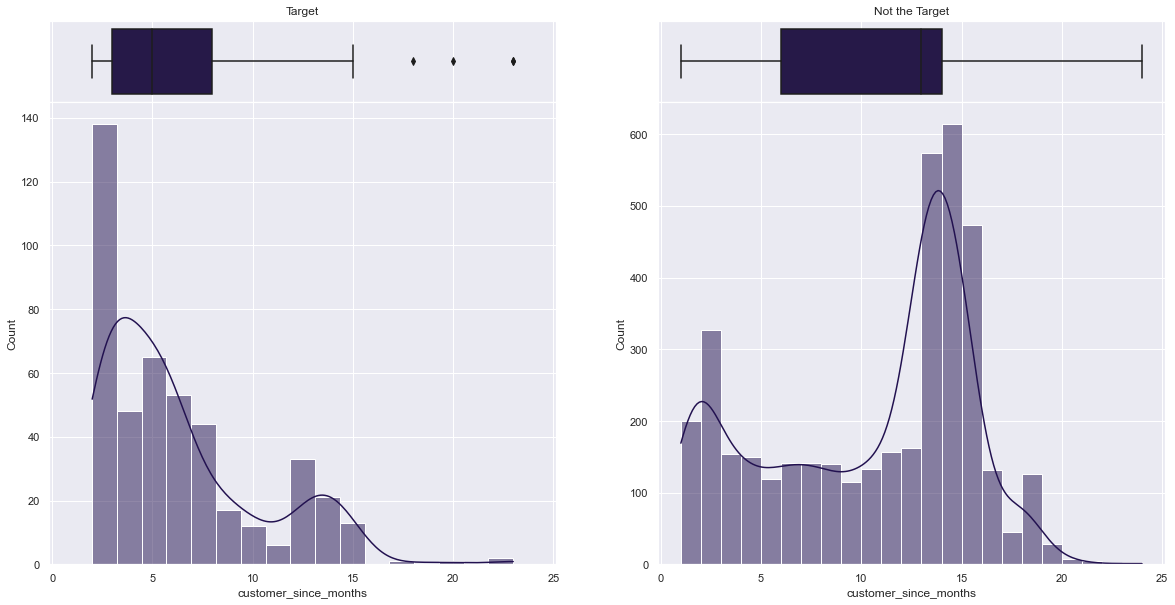

In [11]:
tdc = df[["customer_since_months"]][df["target"]==1]
ntdc = df[["customer_since_months"]][df["target"]==0]

f, [[ax_b1, ax_b2], [ax_h1, ax_h2]] = plt.subplots(2, 2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, 
                                                   figsize=(20, 10))
plt.subplots_adjust(hspace=0)

sns.boxplot(x=tdc["customer_since_months"], ax=ax_b1).set(xlabel=None, title="Target")
sns.histplot(data=tdc, x="customer_since_months", kde=True, ax=ax_h1)

sns.boxplot(x=ntdc["customer_since_months"], ax=ax_b2).set(xlabel=None, title="Not the Target")
sns.histplot(data=ntdc, x="customer_since_months", kde=True, ax=ax_h2)

Values in this colomn are concentrated between 1 to 20.  
Also Targets are concentrated near recently joined customers.  
This makes sense as old users are already familiar with the buisness and dont need much advertisements.  

#### `Old users less likely to be the target ` 

#### Including `new_user` specifies weather the user is new enough or not  
We decide this by dividing customer_since_months at its mean  
condition: dividing `customer_since_months` at its mean  
1 **=>** users are new  
0 **=>** users are old

In [12]:
df.insert(df.shape[1] - 1, "new_user", np.where((
        df["customer_since_months"] < df["customer_since_months"].mean()
    ),
    1, 0
))

<hr>

### comparing return days with customer since months
These two colomns are also soomewhat related and we can get information about frequency of users

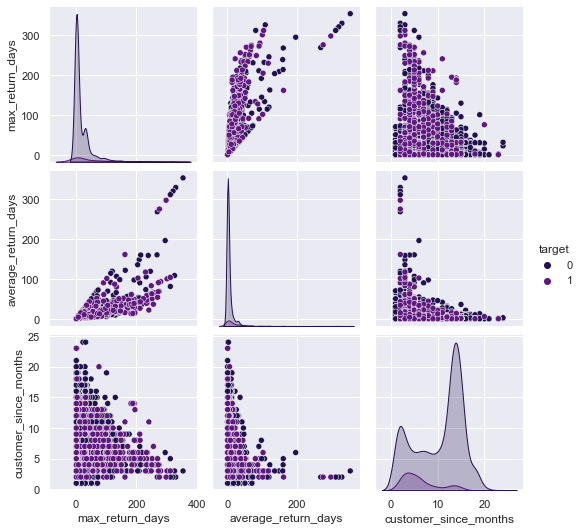

In [13]:
sns.pairplot(df[['max_return_days', 'average_return_days', 'customer_since_months', 'target']]
             .sort_values("target"), hue="target")

#### `Most of the targets are new customers, joined approx before 9 months and the once who return less`
That makes sense!

#### Including `not_frequent` colomn that specifies weather a user is frequent or not  
condition: dividing max_return_days at mean  
1 **=>** specifies customer is not frequent  
0 **=>** are frequent

In [14]:
df.insert(df.shape[1] - 1, "not_frequent", np.where((
        df["average_return_days"] < df["average_return_days"].mean()
    ),
    1, 0
))

<hr>

### The remaining colomns
Lets check the remaining once

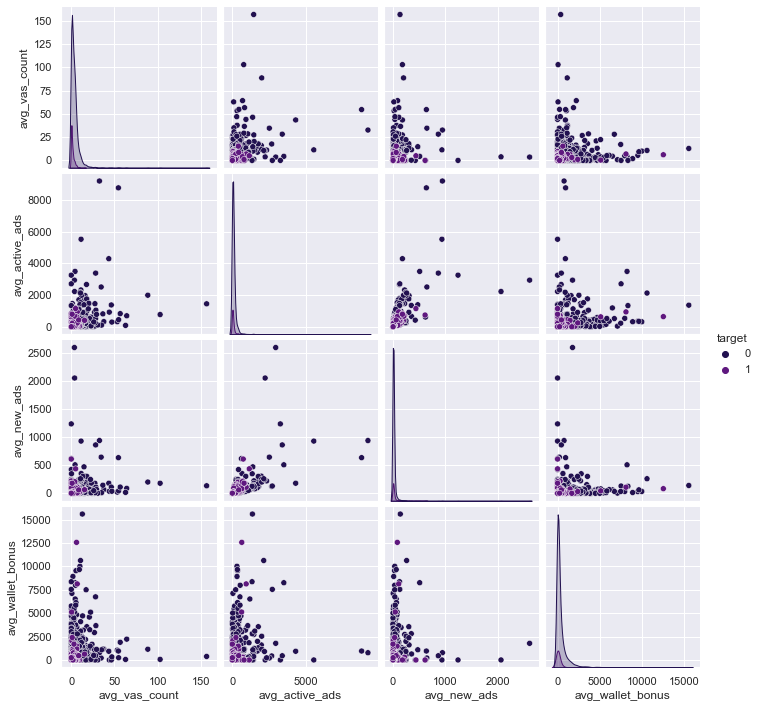

In [15]:
sns.pairplot(df[['avg_vas_count', 'avg_active_ads', 'avg_new_ads', 'avg_wallet_bonus', 'target']]
             .sort_values("target"), hue="target")

#### `Low ads and vas counts are normalt the targets`

#### Inserting `low_ads_vas` that specifies weather the user has less ads or vas count

In [16]:
df.insert(df.shape[1] - 1, "low_ads_vas", np.where((
        (df["avg_active_ads"]<df["avg_active_ads"].mean()) |
        (df["avg_vas_count"]<df["avg_vas_count"].mean())    
    ),
    1, 0
))

<hr>

### Looking at New columns
These are the columns we just created!

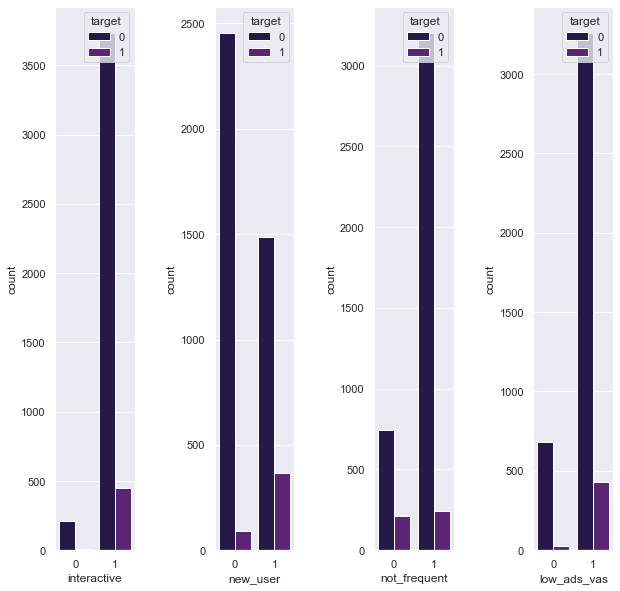

In [17]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(10, 10))
plt.subplots_adjust(wspace=1)

sns.countplot(data=df, x="interactive", hue="target", ax=ax1)
sns.countplot(data=df, x="new_user", hue="target", ax=ax2)
sns.countplot(data=df, x="not_frequent", hue="target", ax=ax3)
sns.countplot(data=df, x="low_ads_vas", hue="target", ax=ax4)

#### Comparing new columns with some important old columns

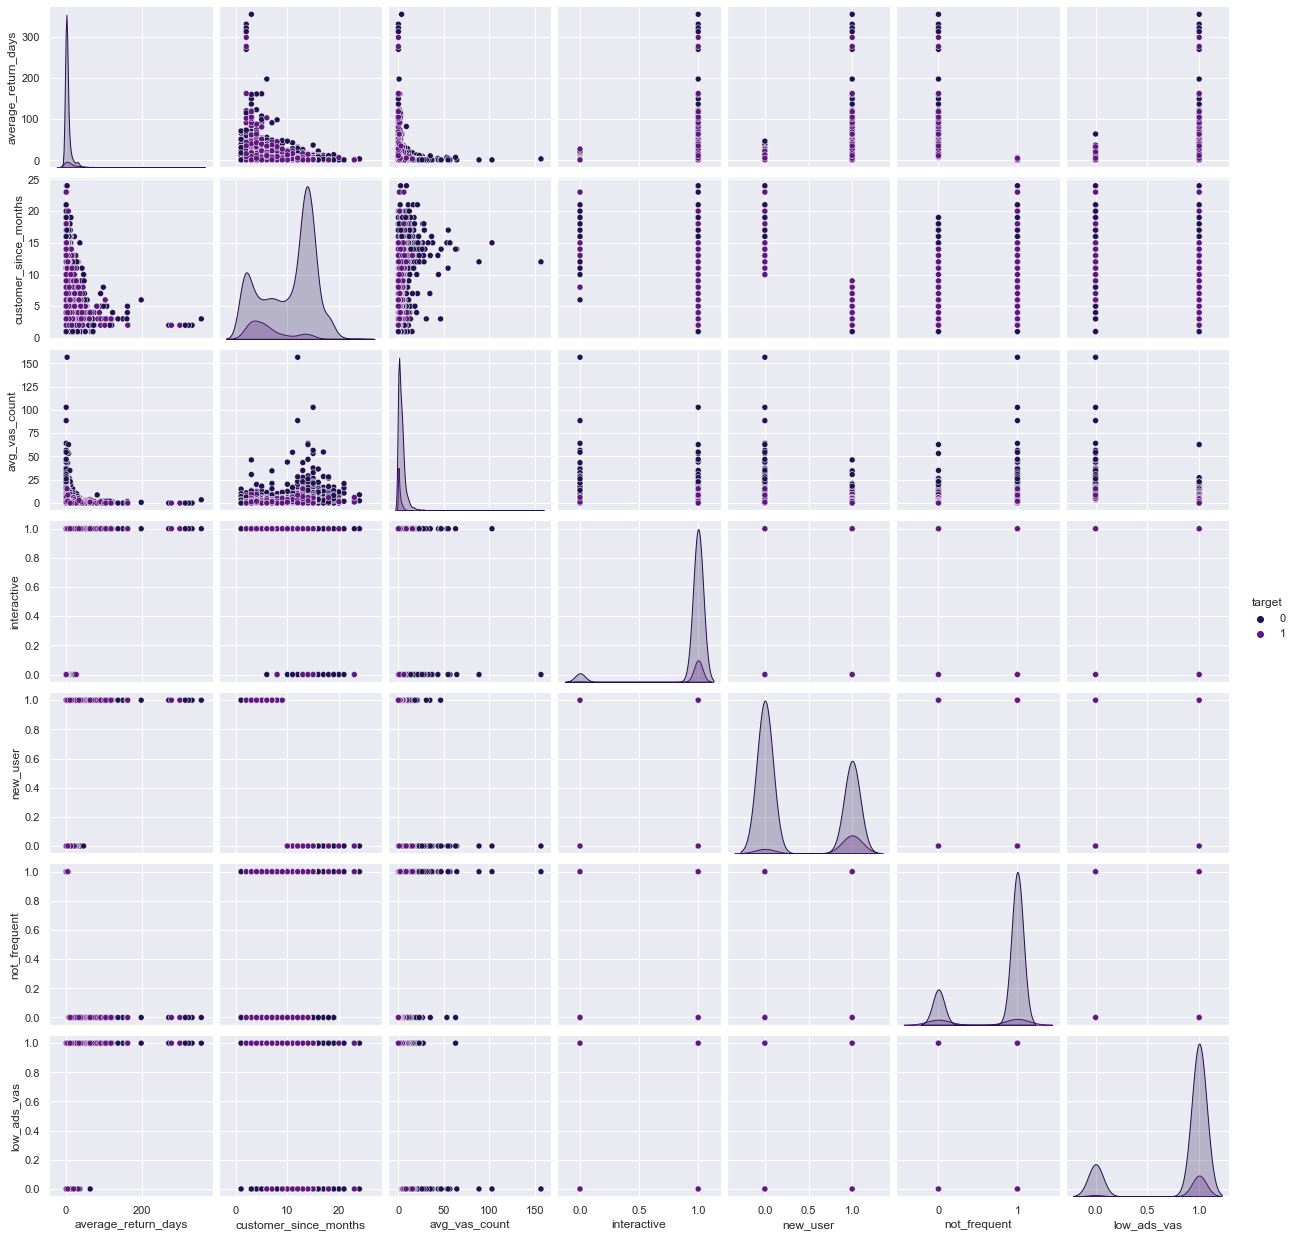

In [18]:
sns.pairplot(df[['average_return_days', 'customer_since_months', 'avg_vas_count', 
                 'interactive', 'new_user', 'not_frequent','low_ads_vas', 'target']]
             .sort_values("target"), hue="target")

<hr>

### Preparing Dataset

#### Removing:  
These colomns are the once with low ANOVA scores or the once with high correlations

**=>** `average_revenue`
**=>** `avg_new_ads`
**=>** `avg_active_ads`
**=>** `business_type`
**=>** `avg_vas_count`

In [19]:
df = df.drop(['average_revenue', 'avg_new_ads', 'avg_active_ads', 'business_type', 'avg_vas_count'], axis=1)

### Restoring Balance

In [20]:
### Saving the data frame for future uses
org = df.copy()

#### Undersmpling using `OneSidedSelection[ CNN + TomekLinks ]` + `NeighbourhoodCleaningRule [ ENN + CNN ]`
OSS algorithm along with NCR will remove outliers and ambiguous records where target==0 so that the remaining data is accurate.

#### Oversampling using `SMOT`
SMOT along with RUS will increase the target==1 records

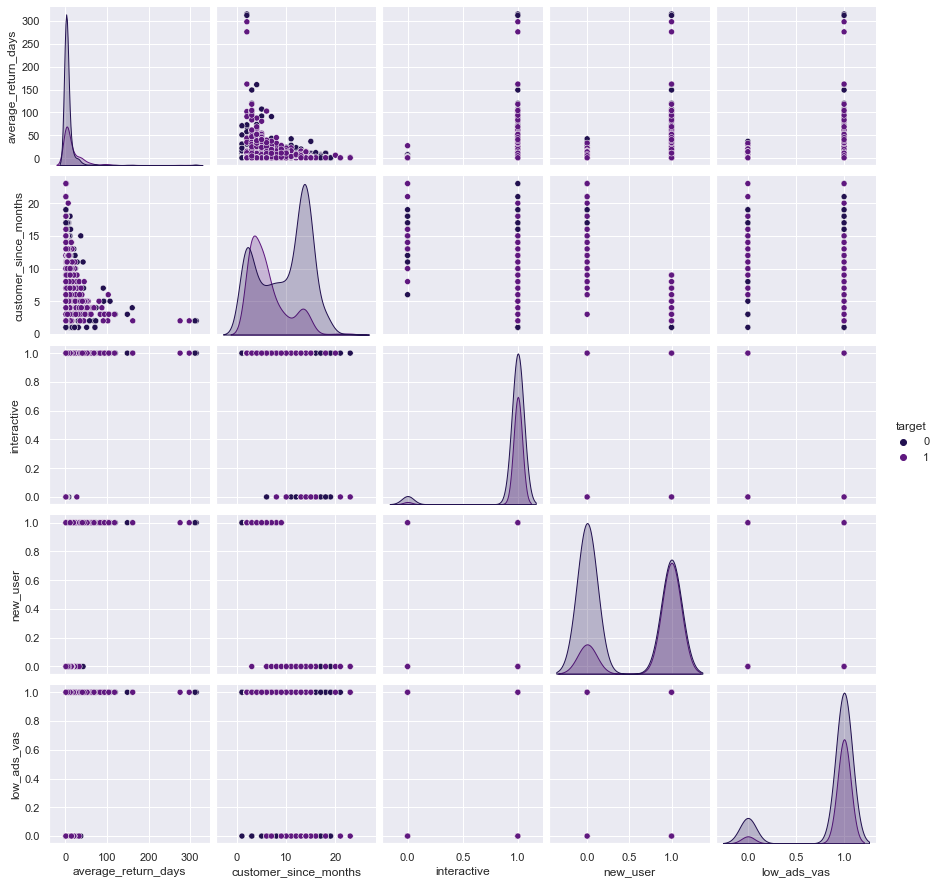

In [21]:
f, v = NeighbourhoodCleaningRule(n_neighbors=3, threshold_cleaning=0.5).fit_resample(df.iloc[:, :-1], df.iloc[:, -1])
f, v = OneSidedSelection(n_neighbors=1, n_seeds_S=400).fit_resample(f, v)

f, v = Pipeline(steps=[('o', SMOTE(sampling_strategy=0.5)), ('u', RandomUnderSampler(sampling_strategy=0.5))]
                 ).fit_resample(f, v)

df = pd.concat([f, v], axis=1)
sns.pairplot(df[['average_return_days', 'customer_since_months', 
                 'interactive', 'new_user', 'low_ads_vas', 'target']]
            .sort_values("target", ascending=True), hue="target")

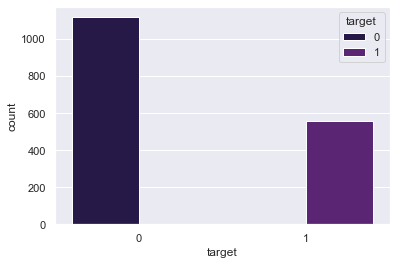

In [22]:
sns.countplot(data=df, x="target", hue='target')

#### Changes are quite evident!

### Normalizing Non Encrypted columns using Standard Scalar

In [23]:
t = pd.DataFrame(StandardScaler().fit_transform(df.iloc[:, :10]))
t.columns = df.iloc[:, :10].columns

df = pd.concat([t, df.iloc[:, 10:]], axis=1)

#### Splitting at 0.1

In [24]:
x_train, x_test, y_train, y_test = train_test_split(df.iloc[:, :-1], df.iloc[:, -1], test_size=0.1, random_state=0)

### Training ML models
We will try all the common ML algorithms and compare the scores

In [25]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

models = {
    "logisticRegression": LogisticRegression(),
    "supportVector": SVC(),
    "KNeighborsClassifier": KNeighborsClassifier(n_neighbors = 3),
    "gaussianNaiveBayes": GaussianNB(),
    "Perceptron": Perceptron(),
    "linearSVC": LinearSVC(),
    "stochasticGradientDescent": SGDClassifier(),
    "decisionTree": DecisionTreeClassifier(),
    "randomForest": RandomForestClassifier(n_estimators=100),
    "adaBoostClassifier": AdaBoostClassifier(),
    "GradientBoostingClassifier": GradientBoostingClassifier(),
    "ExtraTreesClassifier": ExtraTreesClassifier(),
    "XGBClassifier": XGBClassifier()
}

In [26]:
predictions = {}
validation = {}
for key, model in models.items():
    selectedModel = model
    selectedModel.fit(x_train, y_train)
    y_pred = selectedModel.predict(x_test)
    predictions[key] = round(selectedModel.score(x_train, y_train) * 100, 2)
    validation[key] = round(selectedModel.score(x_test, y_test) * 100, 2)

c:\users\our\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


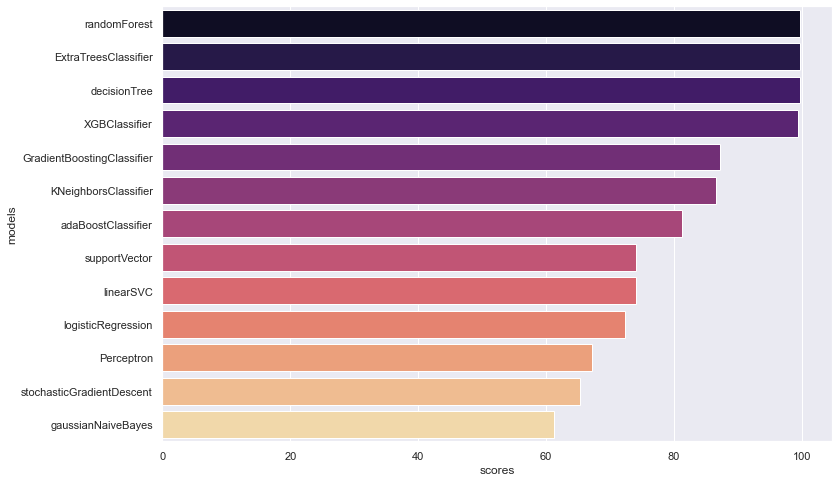

In [35]:
scores = pd.DataFrame({
    "models": list(predictions.keys()), 
    "scores": list(predictions.values()), 
    "validation scores": list(validation.values())}
).sort_values(by=["scores", "validation scores"], ascending=False).reset_index(drop=True)

plt.figure(figsize=(12,8))
sns.barplot(data=scores, x="scores", y="models", palette="magma", hue="")

In [36]:
scores

,models,scores,validation scores
0,randomForest,99.73,80.95
1,ExtraTreesClassifier,99.73,79.76
2,decisionTree,99.73,72.62
3,XGBClassifier,99.40,82.14
4,GradientBoostingClassifier,87.21,80.36
5,KNeighborsClassifier,86.55,75.00
6,adaBoostClassifier,81.18,77.38
7,supportVector,74.02,70.24
8,linearSVC,74.02,68.45
9,logisticRegression,72.37,68.45


### Results
XGBClassifier will be best suited for our training data as it has the highest validation score for comparatively high train score.

### Deeplearning model
We create a simple DNN binary classifier with model shaped like this

```python
_______________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
dense_34 (Dense)             (None, 32)                480       
_________________________________________________________________
dense_35 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 65        
=================================================================
Total params: 2,657
Trainable params: 2,657
Non-trainable params: 0
_________________________________________________________________
```

In [31]:
import keras

Using TensorFlow backend.


In [129]:
model = keras.models.Sequential([
#         keras.layers.Dropout(0.2),
        keras.layers.Dense(32, input_dim=14, activation='relu'),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

#### It might take some time to train the model you wont see it as verbose is set to 0

In [130]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=400, verbose=0)
print("training accuracy: {}\nvalidation accuracy: {}"
      .format(max(history.history["accuracy"]) ,max(history.history["val_accuracy"])))

training accuracy: 0.9226630926132202
validation accuracy: 0.7831325531005859


Text(0.5, 1.0, 'Training and validation loss')

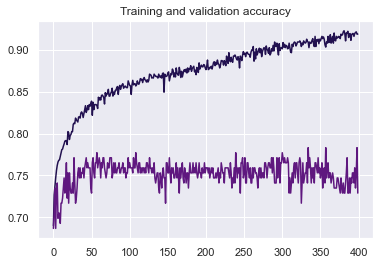

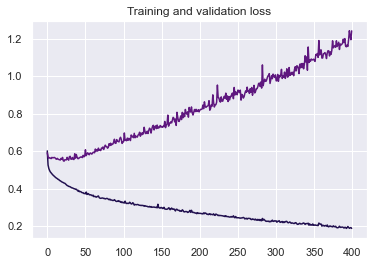

In [131]:
acc = history.history[ 'accuracy' ]
val_acc = history.history[ 'val_accuracy' ]
loss = history.history[ 'loss' ]
val_loss = history.history['val_loss' ]
epochs = range(len(acc))

plt.plot( epochs,     acc )
plt.plot( epochs, val_acc )
plt.title('Training and validation accuracy')
plt.figure()

plt.plot( epochs,     loss )
plt.plot( epochs, val_loss )
plt.title('Training and validation loss')

#### Finally we are getting:  
training accuracy: 92%  
validation accuracy: 78%  
It looks like our model is slightly overfitting we will have to tweak parameters or increase the dataset  

### SHAP
Using SHAP let us look into the randomforest classifier to see which features has the highest impact on the decisions of our model.

In [39]:
import shap

In [41]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(x_train, y_train)

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(x_train)

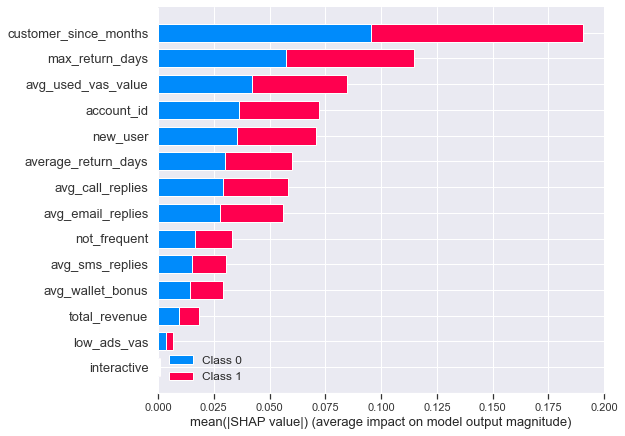

In [43]:
shap.summary_plot(shap_values, x_train)

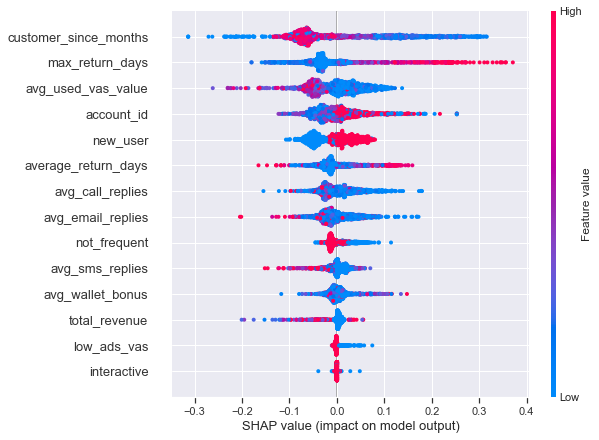

In [134]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(x_train)
shap.summary_plot(shap_values[1], x_train)

### From the above graph we deduce that
if the `customer_since_month` value is `very low` than it has `high impact` to make this customer's **`target value 1`**  
if the `max_return_days` value is `very high` than it has `high impact` to make this customer's **`target value 1`**  
if the `avg_used_vas_values` value is `very low` than it has `medium impact` to make this customer's **`target value is 1`**  
These ar the highest impacting factors deciding wether target is met or not  
and similarly we can see rest of the low impacting column's contribution.